# Data Wrangling for Prediction of Hospital Readmission in Diabetes Patients

## Introduction and a Note about the Data Source

This part of the project begins with the raw data set. I look at various aspects of it (e.g., missing data and relationships between variables) and make changes so that the data becomes more readable to general audiences as well as to software code. I start in the cell below by simply reading in the data and previewing it in the form of connected rows and columns. 

I use data obtained from a previous study done to examine whether performing a certain diagnostic test has an effect on the likelihood of diabetes patients being readmitted to the hospital within 30 days. The initial data set included about 102,000 observations and 50 variables. More information is available here: http://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008. 

In [137]:
%matplotlib inline
import numpy as np
import pandas as pd

#read in data as csv
readmit = pd.read_csv('diabetic_data.csv')
readmit.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Adjustment to Dependent (Outcome) Variable

Because the variable of interest here is whether or not a patient was readmitted within 30 days, it's important to simplify the way that variable's column in the dataset is read. To this end, I change this variable to a binary, with 1 indicating that a patient was readmitted within 30 days and 0 indicating that a patient was not. This binary dynamic is very useful and will appear throughout this project. 

In [23]:
#turn readmission variable into binary (readmitted w/in 30 days or not)
readmit['readmit30'] = np.where(readmit['readmitted'] == '<30', 1, 0)

## Removing Observations that May Cause Bias

Some patients have more than one observation in the data set because they had more than one hospital visit. Since I am only interested in whether or not a patient was readmitted within 30 days, I only need the first visit, or encounter. Leaving additional encounters for a patient could bias the results toward outcomes for such patients, so I remove them here.

I also removed observations that resulted in death or discharge to a hospice, since such patients would not be "eligible" for readmission within 30 days. 

In [70]:
#reduce df so that there's one encounter per patient 
    #use lowest encounter_id, which indicates earliest visit by convention
readmit_sortP = readmit.sort_values(['patient_nbr', 'encounter_id'])
readmit_no_dups = readmit_sortP.drop_duplicates(['patient_nbr'])

    #remove bias in outcome variable by dropping encounters that resulted in death or discharge to hospice 
readmit_no_bias = readmit_no_dups[((readmit_no_dups.discharge_disposition_id != 11) & 
                                          (readmit_no_dups.discharge_disposition_id != 13) &
                                          (readmit_no_dups.discharge_disposition_id != 14) & 
                                          (readmit_no_dups.discharge_disposition_id != 19) & 
                                          (readmit_no_dups.discharge_disposition_id != 20) & 
                                          (readmit_no_dups.discharge_disposition_id != 21))] 
    #check results
discharge = readmit_no_bias.groupby('discharge_disposition_id').size()

## Handling Variables with High Numbers of Missing Values

In the next few steps, I look for patterns in missing data that would indicate that data is absent because of its relationship to a particular value. For example, if the percentage of readmitted patients were much higher for observations with a missing payer code, there could be an underlying explanation for readmission being masked by the lack of information about payer code. I would need to investigate that issue before proceeding with other steps. To start, I look at payer code (i.e., insurer), specialty of the attending physician, and race. Weight is dropped without investigation since 92% of its data were missing. 

The original analysis on which my project is based provided information on the percent of missing data for most variables. Where that information wasn't available, I calculated percentages myself. 

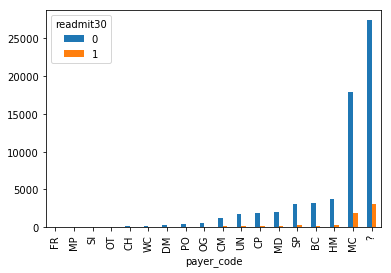

In [71]:
#Are readmission rates approximately even across payer codes (52% missing), including the missing category? 
    #Nothing obvious appears, so variable will be removed from data set. 

    #create cross-tab for initial evaluation and make sorted df for later bar plot
pay_code_ct = pd.crosstab(index = readmit_no_bias['payer_code'], columns = readmit_no_bias['readmit30'])
pay_code_df = pd.DataFrame(pay_code_ct.reset_index()).sort_values(by = 0)

    #make paired bar chart w/ payer codes
levels = pay_code_df.payer_code.tolist()
mapping = {level: i for i, level in enumerate(levels)} #assign nos. to levels 
key = pay_code_df['payer_code'].map(mapping) #map level ordinals to their rows in df
sorting = pay_code_df.iloc[key.argsort()] #create df w/ desired order from matched ordinals
sorting.plot(kind = 'bar', x = 'payer_code')

Note that in the table produced by the cell below, the zero column shows the number of patients who were not readmitted within 30 days, and the 1 column shows no. of patients who were. (Python may offer better table displays, but I haven't found them yet.)

In [118]:
#TRY BOOKMARKED TABLE CODE HERE

#Are readmission rates approximately even across physician specialties (53% missing), including the missing category? 
    
    #There are 73 different specialties, so plots will be unweildy. Look over concordance instead.
        #nothing obvious appears, so remove variable from data set below
spec_ct = pd.crosstab(index = readmit_no_bias['medical_specialty'], columns = readmit_no_bias['readmit30'])
pd.DataFrame(spec_ct).sort_values(by = 0, ascending = False)

readmit30,0,1
medical_specialty,,
?,30535,3104
InternalMedicine,9602,1039
Family/GeneralPractice,4493,485
Emergency/Trauma,4049,344
Cardiology,3905,302
Surgery-General,2021,184
Orthopedics,1016,112
Orthopedics-Reconstructive,972,69
Radiologist,763,58


In [120]:
#drop readmitted (old outcome), weight (92% missing), payer code, and specialty of admitting physician  
readmit_drop = readmit_no_bias.drop(['readmitted', 'weight', 'medical_specialty', 'payer_code'], axis = 1)

## Handling Variables with Low Numbers of Missing Values 
The variables removed in the previous steps all had relatively high percentages of missing data. There are other variables with lower percentages that I expected to drop as a result. Since race can be related to socioeconomic indicators, I looked at its relationship with the dependent variable before removing missing observations. The other variables with lower amounts of missing data were diagnostic codes, and I simply removed the missing data in those cases. 

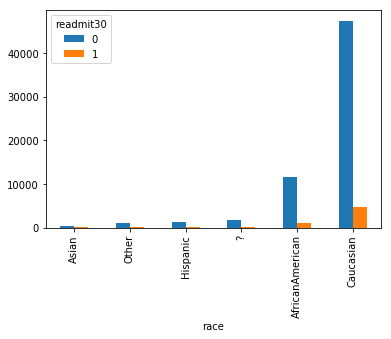

In [133]:
#Is there an association b/w race (3% missing) and readmission (outcome variable)? 

    #create cross-tab for initial evaluation and make df for later bar plot
race_ct = pd.crosstab(index = readmit_drop['race'], columns = readmit_drop['readmit30'])
race_df = pd.DataFrame(race_ct.reset_index()).sort_values(by = 0)

    #make paired bar chart w/ payer codes
Rlevels = race_df.race.tolist()
Rmapping = {level: i for i, level in enumerate(Rlevels)} #assign nos. to levels 
Rkey = race_df['race'].map(Rmapping) #map level ordinals to their rows in df
Rsorting = race_df.iloc[Rkey.argsort()] #create df w/ desired order from matched ordinals
Rsorting.plot(kind = 'bar', x = 'race') 

In [130]:
    #remove observations w/ missing race and diagnoses 1, 2, and 3 (all have <2% of observations missing)
readmit_clean = readmit_drop[((readmit_discharge_clean.race != '?') & 
                                             (readmit_discharge_clean.diag_1 != '?') &
                                             (readmit_discharge_clean.diag_2 != '?') &
                                             (readmit_discharge_clean.diag_3 != '?'))]
readmit_clean.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmit30
4267,24437208,135,Caucasian,Female,[50-60),2,1,1,8,77,...,No,Steady,No,No,No,No,No,Ch,Yes,1
5827,29758806,378,Caucasian,Female,[50-60),3,1,1,2,49,...,No,No,No,No,No,No,No,No,No,0
67608,189899286,729,Caucasian,Female,[80-90),1,3,7,4,68,...,No,No,No,No,No,No,No,No,Yes,0
17494,64331490,774,Caucasian,Female,[80-90),1,1,7,3,46,...,No,No,No,No,No,No,No,Ch,Yes,0
2270,14824206,927,AfricanAmerican,Female,[30-40),1,1,7,5,49,...,No,No,No,No,No,No,No,No,Yes,0


## Export Cleaned Data

In this final step, I change all remaining unknown values from question marks to NaN (Python's NA value) and write a new file that contains the cleaned data. I will use this data set for exploratory and other analyses.

In [141]:
    #change all remaining ?s to NaN and check new dataframe
to_NaN = readmit_clean.replace('?', np.NaN)
pd.options.display.max_rows = 75
checkNA = to_NaN.isnull().sum()

#write csv for exploratory and other analyses
to_NaN.to_csv('readmit_cleaned.csv')